In [6]:
import numpy as np
import signac as sg
from itertools import product
from matplotlib import pyplot as plt
from matplotlib import cm, colors
import pickle

In [14]:
project = sg.get_project()
# for job in project.find_jobs({'doc.S_integrand_calculated': True}):
for job in project.find_jobs():
    print(job.sp)
    print(job.doc)
    if not job.doc.get('S_integrand_calculated'):
        # print('remove')
        # job.remove()
    # with job.data:
    #     print(list(job.data.keys()))
    #     print(len(np.array(job.data['phi_1'])))
    #     print(np.array(job.data['omega_integrand']['wav']))

{'module': 'omnivory', 'C_ijs': [[0, 1], [1, 0]], 'N_n': 100.0}
{'surface_generated': True, 'S_integrand_calculated': True}
{'module': 'chain', 'C_ijs': [[1, 0], [2, 0]], 'N_n': 100.0}
{'surface_generated': True}
{'module': 'chain', 'C_ijs': [[0, 1], [1, 0]], 'N_n': 100.0}
{}
{'module': 'omnivory', 'C_ijs': [[0, 1], [1, 2]], 'N_n': 100.0}
{}
{'module': 'apparent', 'C_ijs': [[0, 2], [2, 0]], 'N_n': 100.0}
{}
{'module': 'omnivory', 'C_ijs': [[0, 2], [1, 2]], 'N_n': 100.0}
{}
{'module': 'apparent', 'C_ijs': [[0, 2], [2, 1]], 'N_n': 100.0}
{}
{'module': 'exploitative', 'C_ijs': [[1, 0], [2, 0]], 'N_n': 100.0}
{}
{'module': 'omnivory', 'C_ijs': [[1, 0], [2, 1]], 'N_n': 100.0}
{}
{'module': 'apparent', 'C_ijs': [[1, 2], [2, 0]], 'N_n': 100.0}
{}
{'module': 'exploitative', 'C_ijs': [[0, 2], [2, 1]], 'N_n': 100.0}
{}
{'module': 'chain', 'C_ijs': [[0, 2], [2, 0]], 'N_n': 100.0}
{}
{'module': 'chain', 'C_ijs': [[0, 1], [0, 2]], 'N_n': 100.0}
{}
{'module': 'chain', 'C_ijs': [[1, 2], [2, 0]], 'N_n

In [23]:
t_bench = 132.3844427499571
size_bench = 592
t_exp = t_bench * (2**(9)/2**(5))
print(t_exp / 60)
(t_exp / t_bench)*size_bench*(1e-3) * 63

35.302518066655225


596.736

## Initialize data

In [9]:
import numpy as np
import signac as sg
from itertools import product
from matplotlib import pyplot as plt
from matplotlib import cm, colors
import pickle

project = sg.get_project()

# List offdiagonal elements in desired sorted order for plotting
C_offdiags = [[0,1], [0,2],
              [1,0], [1,2],
              [2,0], [2,1]]
spec_labels = ['u', 'v', 'w']
C_offdiags_labels = [r'$C_{{{}{}}}$'.format(spec_labels[C_ij[0]], spec_labels[C_ij[1]]) for C_ij in C_offdiags]
# Read in module info from shared data
sd_fn = project.fn('shared_data.h5')
with sg.H5Store(sd_fn).open(mode='r') as sd:
    adj_mats = np.array(sd['adj_mats'])
    modules = np.array([i.decode() for i in sd['modules']])
diagrams = ['w\n|\nv\n|\nu', 'w   v\n \ /\n  u', '  w\n / \\\nu   v', '  w\n / \\\nu - v']

# Organize data into a dict with top key level of modules
data = {}
subkeys = ['nocross_omega', 'nocross_omega_sec_mat', 'omega_mat', 'omega_sec_mats']
for module in modules:
    data.update({module: {}})
for module_i, module in enumerate(modules):
    path = project.path.split('/')[:-1]
    fn = '/'.join(path+['nocross_data_{}_Nn1e3.pkl'.format(module)])
    with open(fn, 'rb') as f:
        nocross_data = pickle.load(f)
        nocross_omega_sec_mat = nocross_data['omega_sec_mat']
        nocross_omega = nocross_data['omega']
    data[module].update({'nocross_omega_sec_mat': nocross_omega_sec_mat})
    data[module].update({'nocross_omega': nocross_omega})

    omega_mat = np.zeros((3,3))
    omega_sec_mats = []
    for C_offdiag in C_offdiags:
        for job in project.find_jobs({'module': module, 'C_offdiag': C_offdiag}):
            with job.data:
                omega_sum = 0.0
                omega_sec_mat = np.zeros((2,2,4))
                # Loop over parameter space sections 
                for phi_lims in product(range(2), range(2), range(4)):
                    conds = []
                    for lim_i, lim in enumerate(phi_lims):
                        conds.append(np.array(job.data['phi_'+str(lim_i+1)]) > lim*np.pi/2)
                        conds.append(np.array(job.data['phi_'+str(lim_i+1)]) < (lim + 1)*np.pi/2)
                    cond = np.all(conds, axis=0)
                    omega_integrand_sec = np.array(job.data['omega_integrand/wav'])[cond] + np.array(job.data['omega_integrand/st'])[cond]
                    i, j, k = phi_lims
                    omega_sec_mat[i, j, k] = sum(omega_integrand_sec) / sum(cond)
                    omega_sum += sum(omega_integrand_sec)
                omega_sec_mats.append(omega_sec_mat)
                i, j = job.sp['C_offdiag']
                omega_mat[i, j] = (omega_sum / len(job.data['phi_1'])) 
                data[module].update({'omega_mat': omega_mat})
    data[module].update({'omega_sec_mats': omega_sec_mats})

## Plotting functions

In [2]:
def heatmap(data, row_labels, col_labels, ax, fig,
            xlabel="", ylabel="", title="", cbarlabel="", 
            savefig=False, fn='', path = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/',
            **kwargs):
    im = ax.imshow(data, **kwargs)
    cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.8)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, fontsize=15, labelpad=20)
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_xticklabels(col_labels, fontsize=12)
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_yticklabels(row_labels, fontsize=12)
    ax.spines[:].set_visible(False)
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_title(title, fontsize=20)
    if savefig:
        if fn == '':
            fn = str(int(np.random.sample()*1e5))+'.png'
        fig.savefig(path + fn)

In [3]:
def heatmap_sub(data, row_labels, col_labels, ax,
            xlabel="", ylabel="", title="", cbarlabel="", 
            axt=False, xtlabels=[], xtlabel="", **kwargs):
    im = ax.imshow(data, **kwargs)
    cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.8)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, fontsize=20, labelpad=20)
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_xticklabels(col_labels, fontsize=12)
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_yticklabels(row_labels, fontsize=12)
    ax.spines[:].set_visible(False)
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_xlabel(xlabel, fontsize=20)
    if axt:
        ax_t = ax.secondary_xaxis('top')
        ax_t.set_xticks(np.arange(data.shape[1]))
        ax_t.set_xticklabels(xtlabels, fontsize=12)
        ax_t.set_xlabel(xtlabel, fontsize=20)
    if title != "":
        ax.set_title(title, fontsize=20)

## omega C_ij

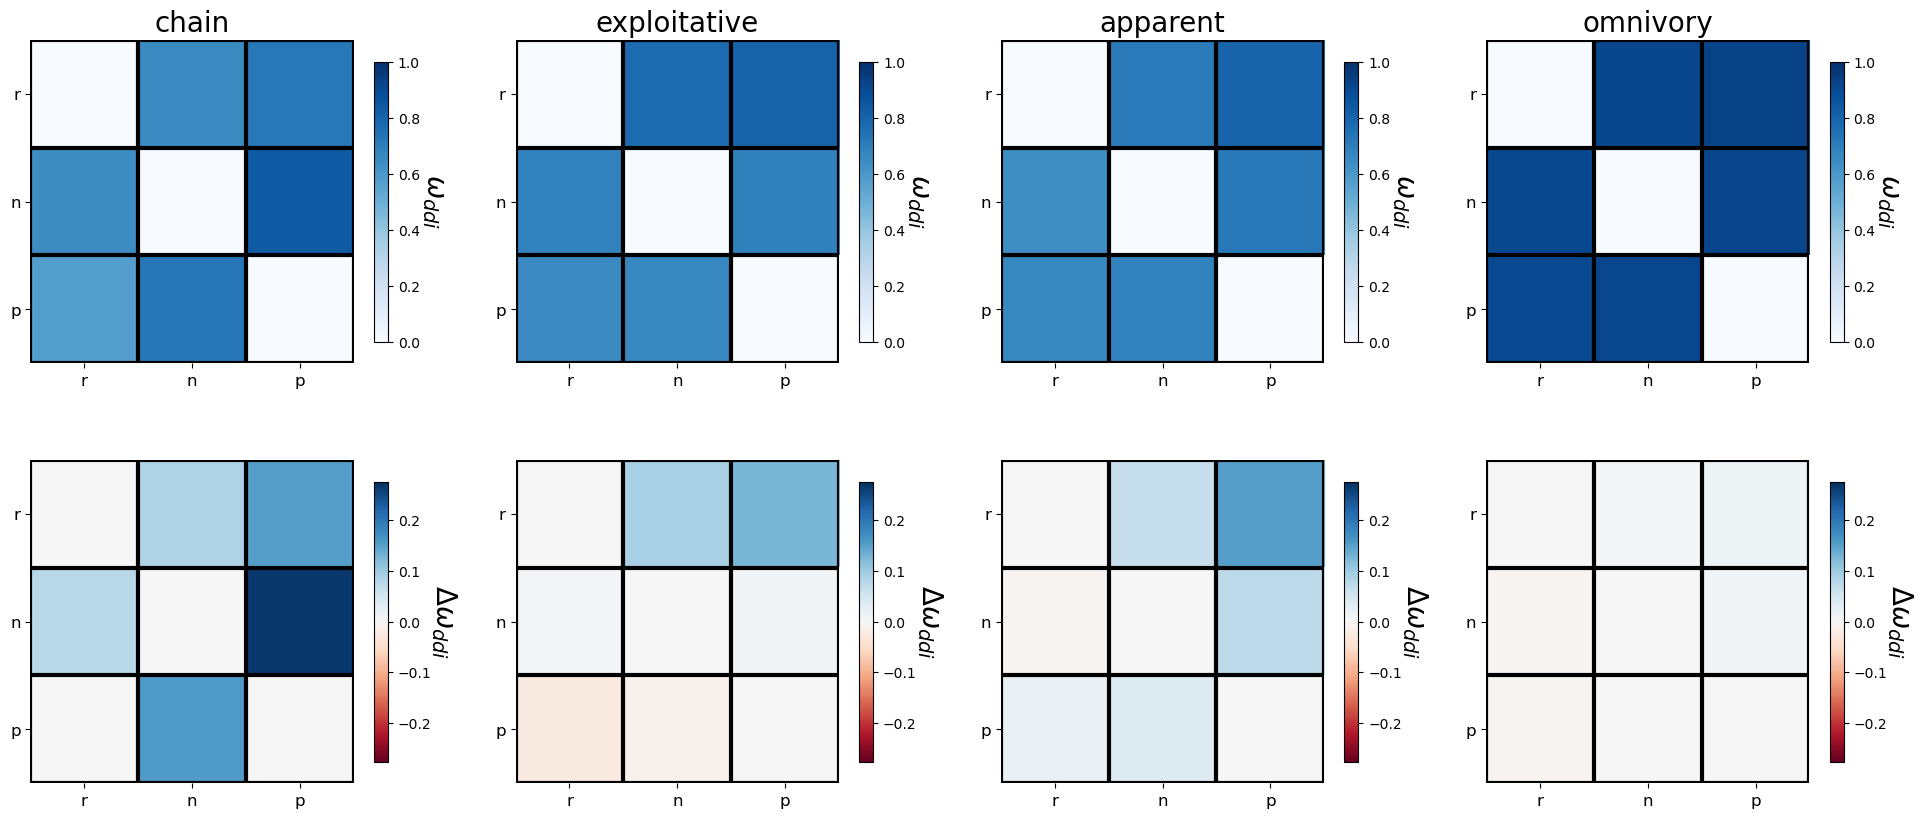

In [4]:
plt.figure( figsize=(6*len(modules), 5*2) )
xticks = ['r','n','p']
yticks = ['r','n','p']
for module_i, module in enumerate(modules):
    nocross_omega = data[module]['nocross_omega']
    omega_mat = data[module]['omega_mat']
    n = module_i + 1
    ax = plt.subplot(2, len(modules), n)
    norm = colors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1.)
    heatmap_sub(omega_mat, yticks, xticks, ax=ax, 
                cbarlabel=r"$\omega_{ddi}$", cmap="Blues", norm=norm,
                title="{}".format(module))
    n = len(modules) + module_i + 1
    ax = plt.subplot(2, len(modules), n)
    omega_diff_mat = omega_mat - nocross_omega*(-1.*(np.eye(3)-1))
    bound = 0.275
    norm = colors.TwoSlopeNorm(vmin=-bound, vcenter=0, vmax=bound)
    heatmap_sub(omega_diff_mat, yticks, xticks, ax=ax, 
                cbarlabel=r"$\Delta\omega_{ddi}$", cmap="RdBu", norm=norm)
                # title="Delta omega {}".format(module))

savefig = False
if savefig:
    path = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
    fn='omega_Cij.png'
    plt.savefig(path + fn, bbox_inches='tight')

## omega per section

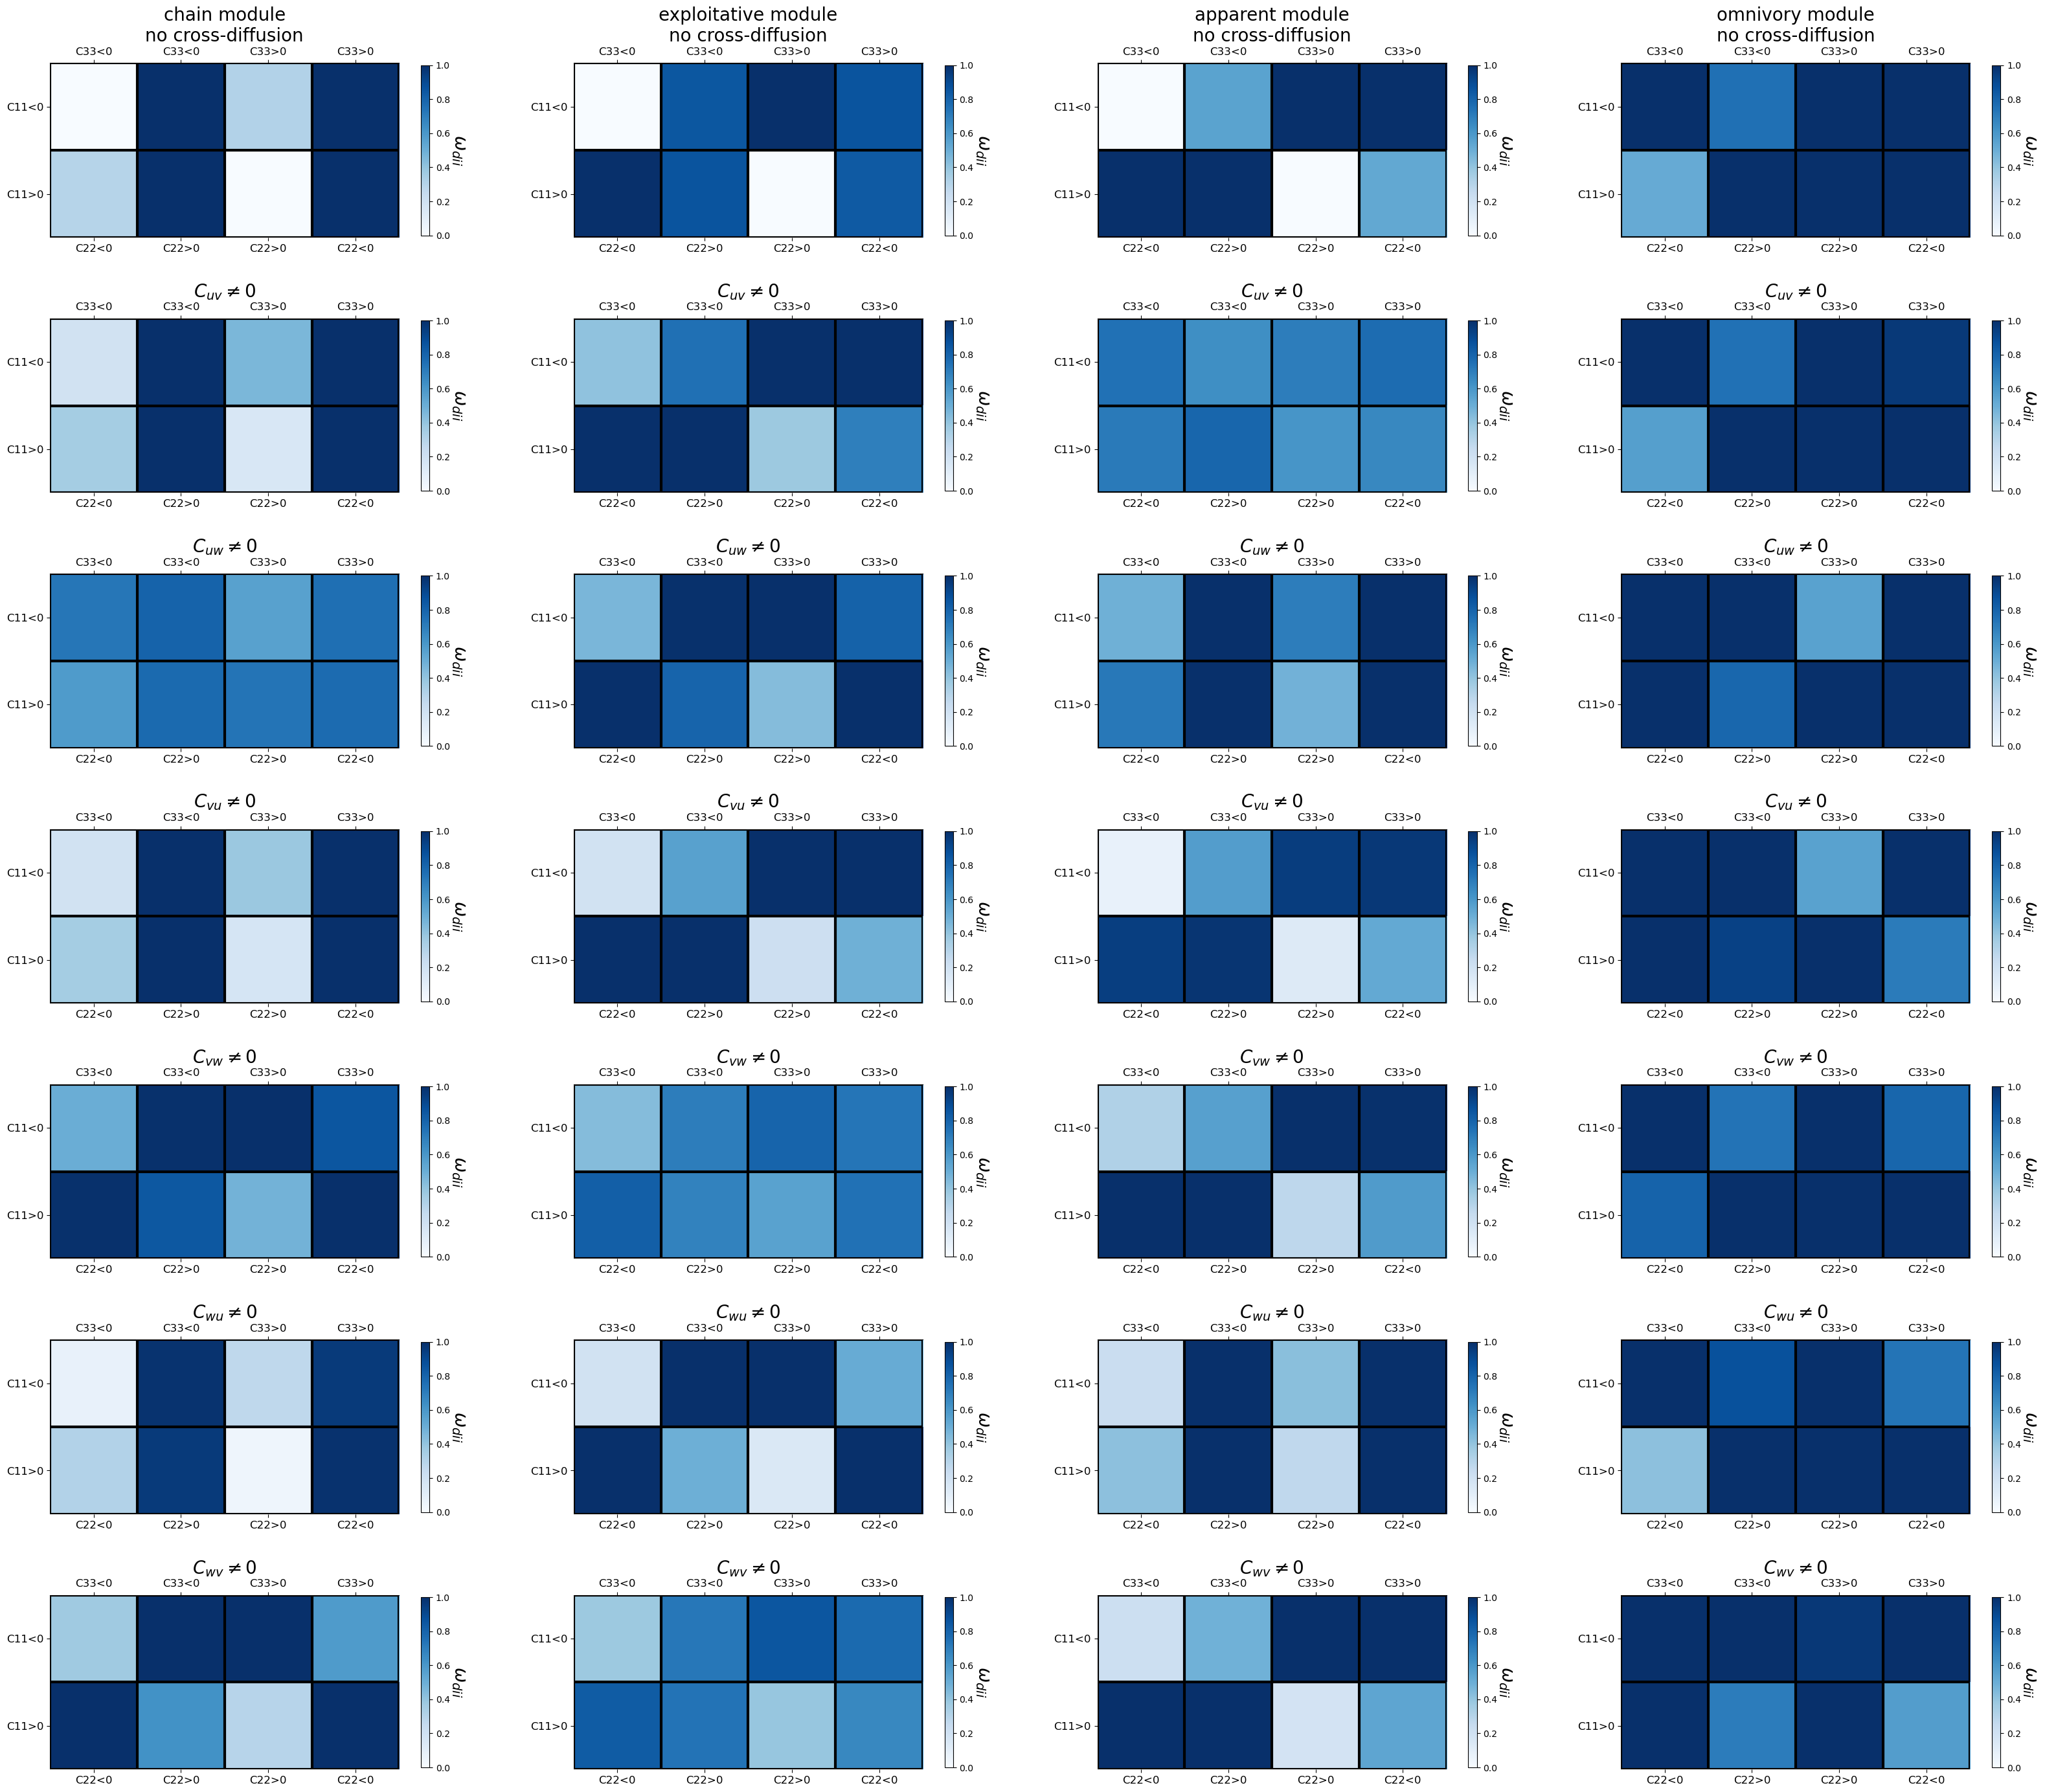

In [5]:
plt.figure( figsize=(10*len(modules), 5*(len(C_offdiags) + 1)) )
xticks = ['C22<0','C22>0','C22>0','C22<0']
xtticks = ['C33<0', 'C33<0', 'C33>0', 'C33>0']
yticks = ['C11<0','C11>0']
for module_i, module in enumerate(modules):
    nocross_omega_sec_mat = data[module]['nocross_omega_sec_mat']
    omega_sec_mats = data[module]['omega_sec_mats']
    n = module_i + 1
    ax = plt.subplot(len(C_offdiags)+1, len(modules), n)
    norm = colors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1.)
    cmap = 'Blues'
    heatmap_sub(nocross_omega_sec_mat, yticks, xticks, ax=ax, axt=True, xtlabels=xtticks,
            cbarlabel=r"$\omega_{dii}$", cmap="Blues", norm=norm,
            title="{} module\nno cross-diffusion".format(module))

    # for i in range(len(C_offdiags)):
    for C_offdiag_i, C_offdiag in enumerate(C_offdiags):
        mean_omega_sec_mat = np.mean(omega_sec_mats[C_offdiag_i], axis=0)
        norm = colors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1.)
        cmap = 'Blues'
        # Cij = "C{}{}".format(str(C_offdiags[i][0]+1), str(C_offdiags[i][1]+1))
        i, j = C_offdiag
        n = (C_offdiag_i + 1)*len(modules) + module_i + 1
        ax = plt.subplot(len(C_offdiags)+1, len(modules), n)
        heatmap_sub(mean_omega_sec_mat, yticks, xticks, ax=ax, 
                    axt=True, xtlabels=xtticks,
                    cbarlabel=r"$\omega_{dii}$", cmap="Blues", norm=norm, 
                    title=r'$C_{{{}{}}} \neq 0$'.format(spec_labels[i], spec_labels[j]))

savefig = True
if savefig:
    path = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
    fn='omega_sec.png'
    plt.savefig(path + fn, bbox_inches='tight')

## Phase

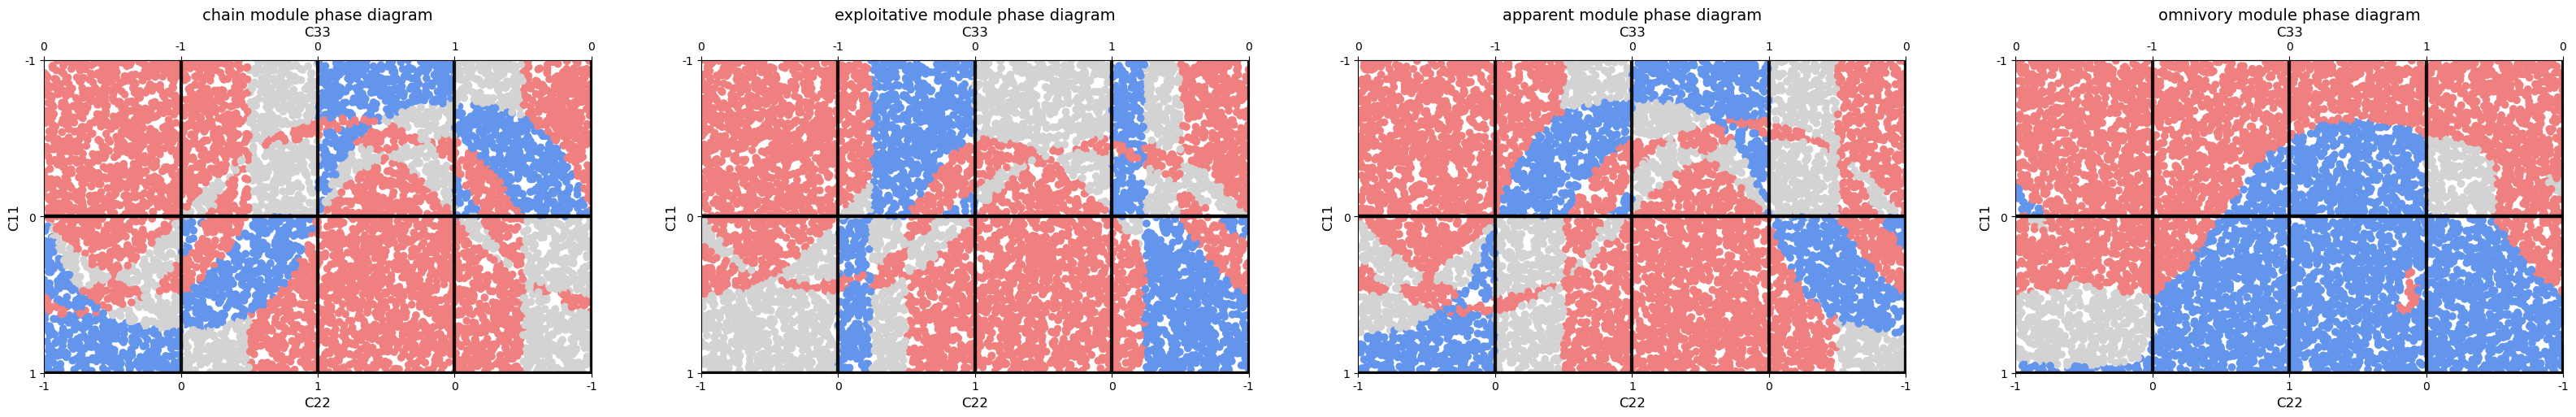

In [10]:
figpath = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
figfn = 'phase_nocross.png'
path = project.path.split('/')[:-1]
plt.figure( figsize=(10*len(modules), 5) )
for module_i, module in enumerate(modules):
    n = module_i + 1
    ax = plt.subplot(1, len(modules), n)
    fn = '/'.join(path+['nocross_data_{}_Nn1e3.pkl'.format(module)])
    with open(fn, 'rb') as f:
        nocross_data = pickle.load(f)
        st = np.array(nocross_data['omega_integrand/st'])
        wav = np.array(nocross_data['omega_integrand/wav'])
        stab = np.array(nocross_data['omega_integrand/stab'])
        xs = np.array(nocross_data['phi_2'])
        ys = np.array(nocross_data['phi_1'])
        colors = []
        for i in range(len(st)):
            '''first just check always one of three possibilities; also helpful for seeing the density of samples'''
            # if st[i]: colors.append('black')
            # elif wav[i]: colors.append('black')
            # elif stab[i]: colors.append('black')
            # else: colors.append('red')
            '''now actually plot'''
            if st[i]: colors.append('cornflowerblue')
            elif wav[i]: colors.append('lightcoral')
            # elif wav[i]: colors.append('cornflowerblue')
            elif stab[i]: colors.append('lightgrey')
    lw = 3
    ls = '-'
    c ='black'
    alpha = 0.7
    ax_label_fontsize = 12
    xticks, yticks = ([0.], [0.])
    for phi_lims in product(range(2), range(4)):
        x = (phi_lims[1]+1)*np.pi/2
        xticks.append(x)
        y = (phi_lims[0]+1)*np.pi/2
        yticks.append(y)
        ax.axvline(x, c=c, linewidth=lw, ls=ls, alpha=alpha)
        ax.axhline(y, c=c, linewidth=lw, ls=ls, alpha=alpha)
    xticks = np.unique(xticks)
    yticks = np.unique(yticks)
    ax.scatter(xs, ys, c=colors)
    ax.set_title('{} module phase diagram'.format(module), fontsize=14)
    ax.set_ylabel('C11', fontsize=ax_label_fontsize)
    ax.set_xlim(0,x)
    ax.set_ylim(0,y)
    ax.invert_yaxis()
    ax.set_yticks(yticks)
    ylabels = ['-1', '0', '1']
    ax.set_yticklabels(ylabels)
    ax.set_xticks(xticks)
    xblabels = ['-1', '0', '1', '0', '-1']
    ax.set_xticklabels(xblabels)
    ax.set_xlabel('C22', fontsize=ax_label_fontsize)
    ax_t = ax.secondary_xaxis('top')
    xtlabels = ['0', '-1', '0', '1', '0']
    ax_t.set_xticks(xticks)
    ax_t.set_xticklabels(xtlabels)
    ax_t.set_xlabel('C33', fontsize=ax_label_fontsize)
    # break

savefig = True
if savefig:
    plt.savefig(figpath + figfn, bbox_inches='tight')

##### hardcoded Jacobian test

Text(0.5, 0, 'C33')

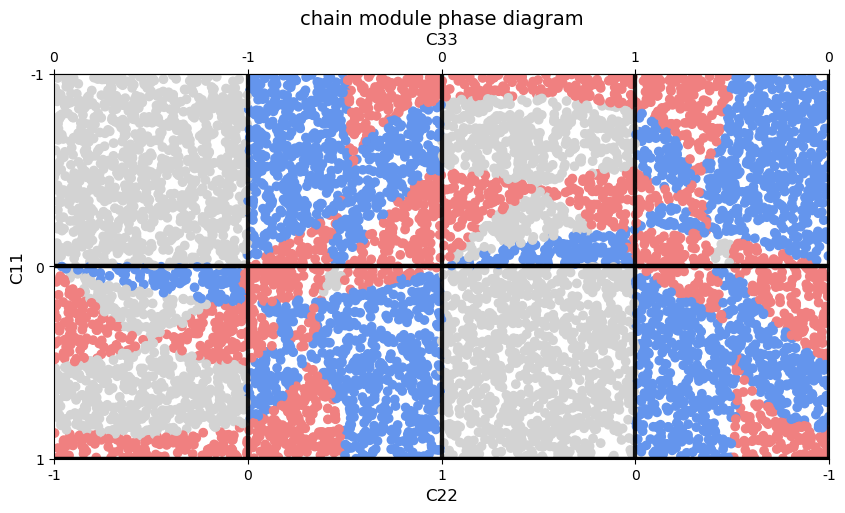

In [7]:

path = project.path.split('/')[:-1]
plt.figure( figsize=(10, 5) )
ax = plt.subplot()
fn = '/'.join(path+['nocross_data_chain_Nn1e3_Jtest.pkl'])
with open(fn, 'rb') as f:
    nocross_data = pickle.load(f)
    st = np.array(nocross_data['omega_integrand/st'])
    wav = np.array(nocross_data['omega_integrand/wav'])
    stab = np.array(nocross_data['omega_integrand/stab'])
    xs = np.array(nocross_data['phi_2'])
    ys = np.array(nocross_data['phi_1'])
    colors = []
    for i in range(len(st)):
        '''first just check always one of three possibilities; also helpful for seeing the density of samples'''
        # if st[i]: colors.append('black')
        # elif wav[i]: colors.append('black')
        # elif stab[i]: colors.append('black')
        # else: colors.append('red')
        '''now actually plot'''
        if st[i]: colors.append('cornflowerblue')
        elif wav[i]: colors.append('lightcoral')
        # elif wav[i]: colors.append('cornflowerblue')
        elif stab[i]: colors.append('lightgrey')
lw = 3
ls = '-'
c ='black'
alpha = 0.7
ax_label_fontsize = 12
xticks, yticks = ([0.], [0.])
for phi_lims in product(range(2), range(4)):
    # print(phi_lims)
    x = (phi_lims[1]+1)*np.pi/2
    xticks.append(x)
    y = (phi_lims[0]+1)*np.pi/2
    yticks.append(y)
    ax.axvline(x, c=c, linewidth=lw, ls=ls, alpha=alpha)
    ax.axhline(y, c=c, linewidth=lw, ls=ls, alpha=alpha)
xticks = np.unique(xticks)
yticks = np.unique(yticks)
ax.scatter(xs, ys, c=colors)
ax.set_title('{} module phase diagram'.format('chain'), fontsize=14)
ax.set_ylabel('C11', fontsize=ax_label_fontsize)
ax.set_xlim(0,x)
ax.set_ylim(0,y)
ax.invert_yaxis()
ax.set_yticks(yticks)
ylabels = ['-1', '0', '1']
ax.set_yticklabels(ylabels)
ax.set_xticks(xticks)
xblabels = ['-1', '0', '1', '0', '-1']
ax.set_xticklabels(xblabels)
ax.set_xlabel('C22', fontsize=ax_label_fontsize)
ax_t = ax.secondary_xaxis('top')
xtlabels = ['0', '-1', '0', '1', '0']
ax_t.set_xticks(xticks)
ax_t.set_xticklabels(xtlabels)
ax_t.set_xlabel('C33', fontsize=ax_label_fontsize)

## Positive diagonal, constrained off-diagonal

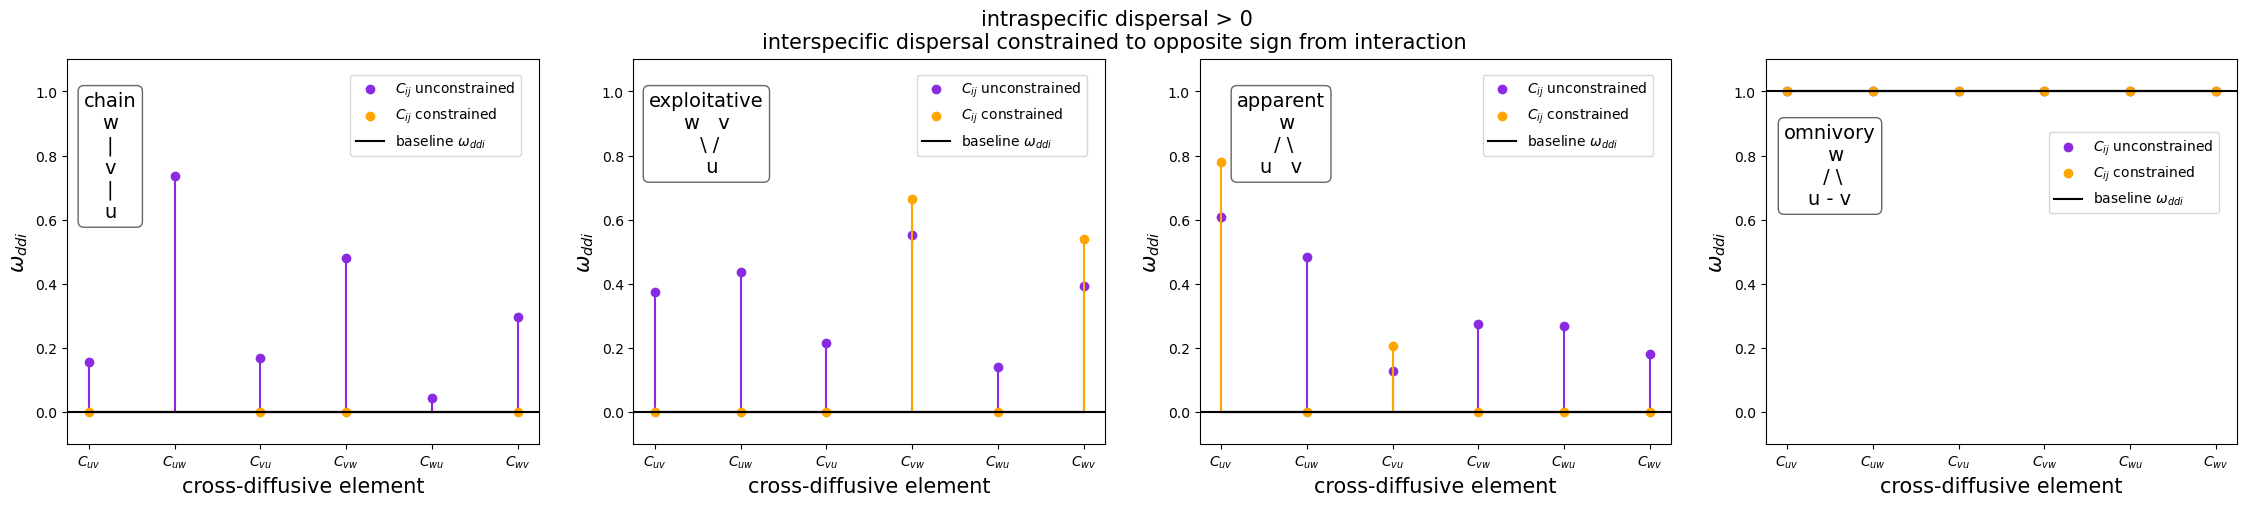

In [8]:
plt.figure(figsize=(7*len(modules), 5))
plt.suptitle('intraspecific dispersal > 0\ninterspecific dispersal constrained to opposite sign from interaction ', fontsize=15)
for module_i, module in enumerate(modules):
    ax = plt.subplot(1, len(modules), module_i + 1)
    nocross_omega_sec_mat = data[module]['nocross_omega_sec_mat']
    omega_mat = data[module]['omega_mat']
    omega_sec_mats = data[module]['omega_sec_mats']
    omegas = []
    'Only include positive diagonal elements, sign of cross diffusion depends on interactions'
    for idx, C_offdiag in enumerate(C_offdiags):
        omega_sec_mat = omega_sec_mats[idx]
        adj = adj_mats[modules==module][0]
        i, j = C_offdiag
        if adj[i,j] == 1.0:
            # j feeds on i -> C_ij > 0
            phi_lim_0 = 1
        elif adj[j,i] == 1.0:
            # i feeds on j -> C_ij < 0
            phi_lim_0 = 0
        else:
            # Some special cases where C_ij != 0 for indirect interactions
            if (module == 'exploitative') and (C_offdiag in [[1,2], [2,1]]):
                # Negative interaction btwn predators in exploitative -> C_ij > 0
                phi_lim_0 = 1
            elif (module == 'apparent') and (C_offdiag in [[0,1], [1,0]]):
                # Negative interaction btwn prey in apparent -> C_ij > 0
                '''Not really sure about this assumption'''
                phi_lim_0 = 1
            # C_ij = 0 for all cases besides those above
            else:
                phi_lim_0 = np.nan
        omega = omega_sec_mat[phi_lim_0,1,2] if not np.isnan(phi_lim_0) else np.nan
        omegas.append(omega)
    delta_omegas = np.array(omegas) - nocross_omega_sec_mat[1,2]
    omegas_noconstraint = [np.mean(omega_sec_mat, axis=0)[1,2] for omega_sec_mat in omega_sec_mats]

    xs = range(len(omegas))
    ax.stem(xs, omegas_noconstraint, bottom=nocross_omega_sec_mat[1,2], basefmt='black', 
            linefmt='blueviolet')
    ax.scatter([],[],color='blueviolet', label=r'$C_{ij}$ unconstrained')
    ax.stem(xs, omegas, bottom=nocross_omega_sec_mat[1,2], basefmt='black', 
            linefmt='orange')
    ax.scatter([],[],color='orange', label=r'$C_{ij}$ constrained')
    ax.axhline(nocross_omega_sec_mat[1,2], color='black', label=r'baseline $\omega_{ddi}$')
    ax.set_xticks(xs)
    ax.set_xticklabels(C_offdiags_labels)
    legsize = 10
    xys = [(0.25, 1.),(0.6, 1.),(0.7, 1.),(0.5, 0.9)]
    leglocs = [(0.6,0.75),(0.6,0.75),(0.6,0.75),(0.6,0.6)]
    ax.legend(loc=leglocs[module_i], prop={'size': legsize})
    ax.annotate(module+'\n'+diagrams[module_i], xy=xys[module_i], xycoords='data',
            size=14, ha='center', va='top',
            bbox=dict(boxstyle='round', fc='w', alpha=0.6)) 
    ax.set_ylim(-0.1,1.1)
    ax.set_ylabel(r'$\omega_{ddi}$', fontsize=15)
    ax.set_xlabel('cross-diffusive element', fontsize=15)
    
savefig = False
if savefig:
    path = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
    fn='omega_constrained.png'
    plt.savefig(path + fn, bbox_inches='tight')